In [4]:
from datasets import load_dataset

dataset = load_dataset("inria-soda/tabular-benchmark", "reg_num_wine_quality")
df = dataset["train"].to_pandas()

df.head()
print(df.describe())


C:\Users\79833\PyCharmMiscProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


       fixed.acidity  volatile.acidity  citric.acid  residual.sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free.sulfur.dioxide  total.sulfur.dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

Хотим научиться определять качество вина по его параметрам

In [5]:
print("Размер:", df.shape)
print("\nИнформация:")
print(df.info())
print("\nПропуски:")
print(df.isna().sum())
print("\nРаспределение классов:")
print(df['quality'].value_counts())


Размер: (6497, 12)

Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         6497 non-null   float64
 1   volatile.acidity      6497 non-null   float64
 2   citric.acid           6497 non-null   float64
 3   residual.sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free.sulfur.dioxide   6497 non-null   float64
 6   total.sulfur.dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB
None

Пропуски:
fixed.acidity           0
volatile.acidity        0
citric.acid             0


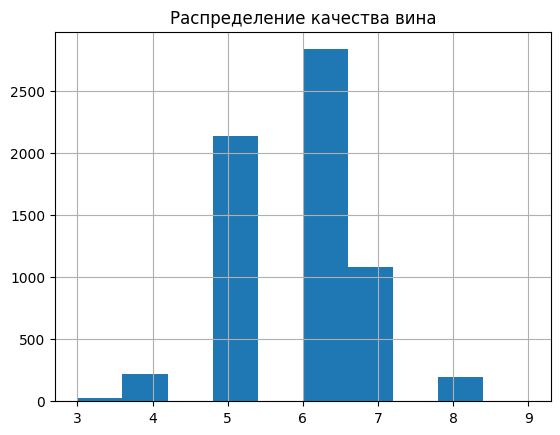

In [6]:
import matplotlib.pyplot as plt

df['quality'].hist()
plt.title("Распределение качества вина")
plt.show()


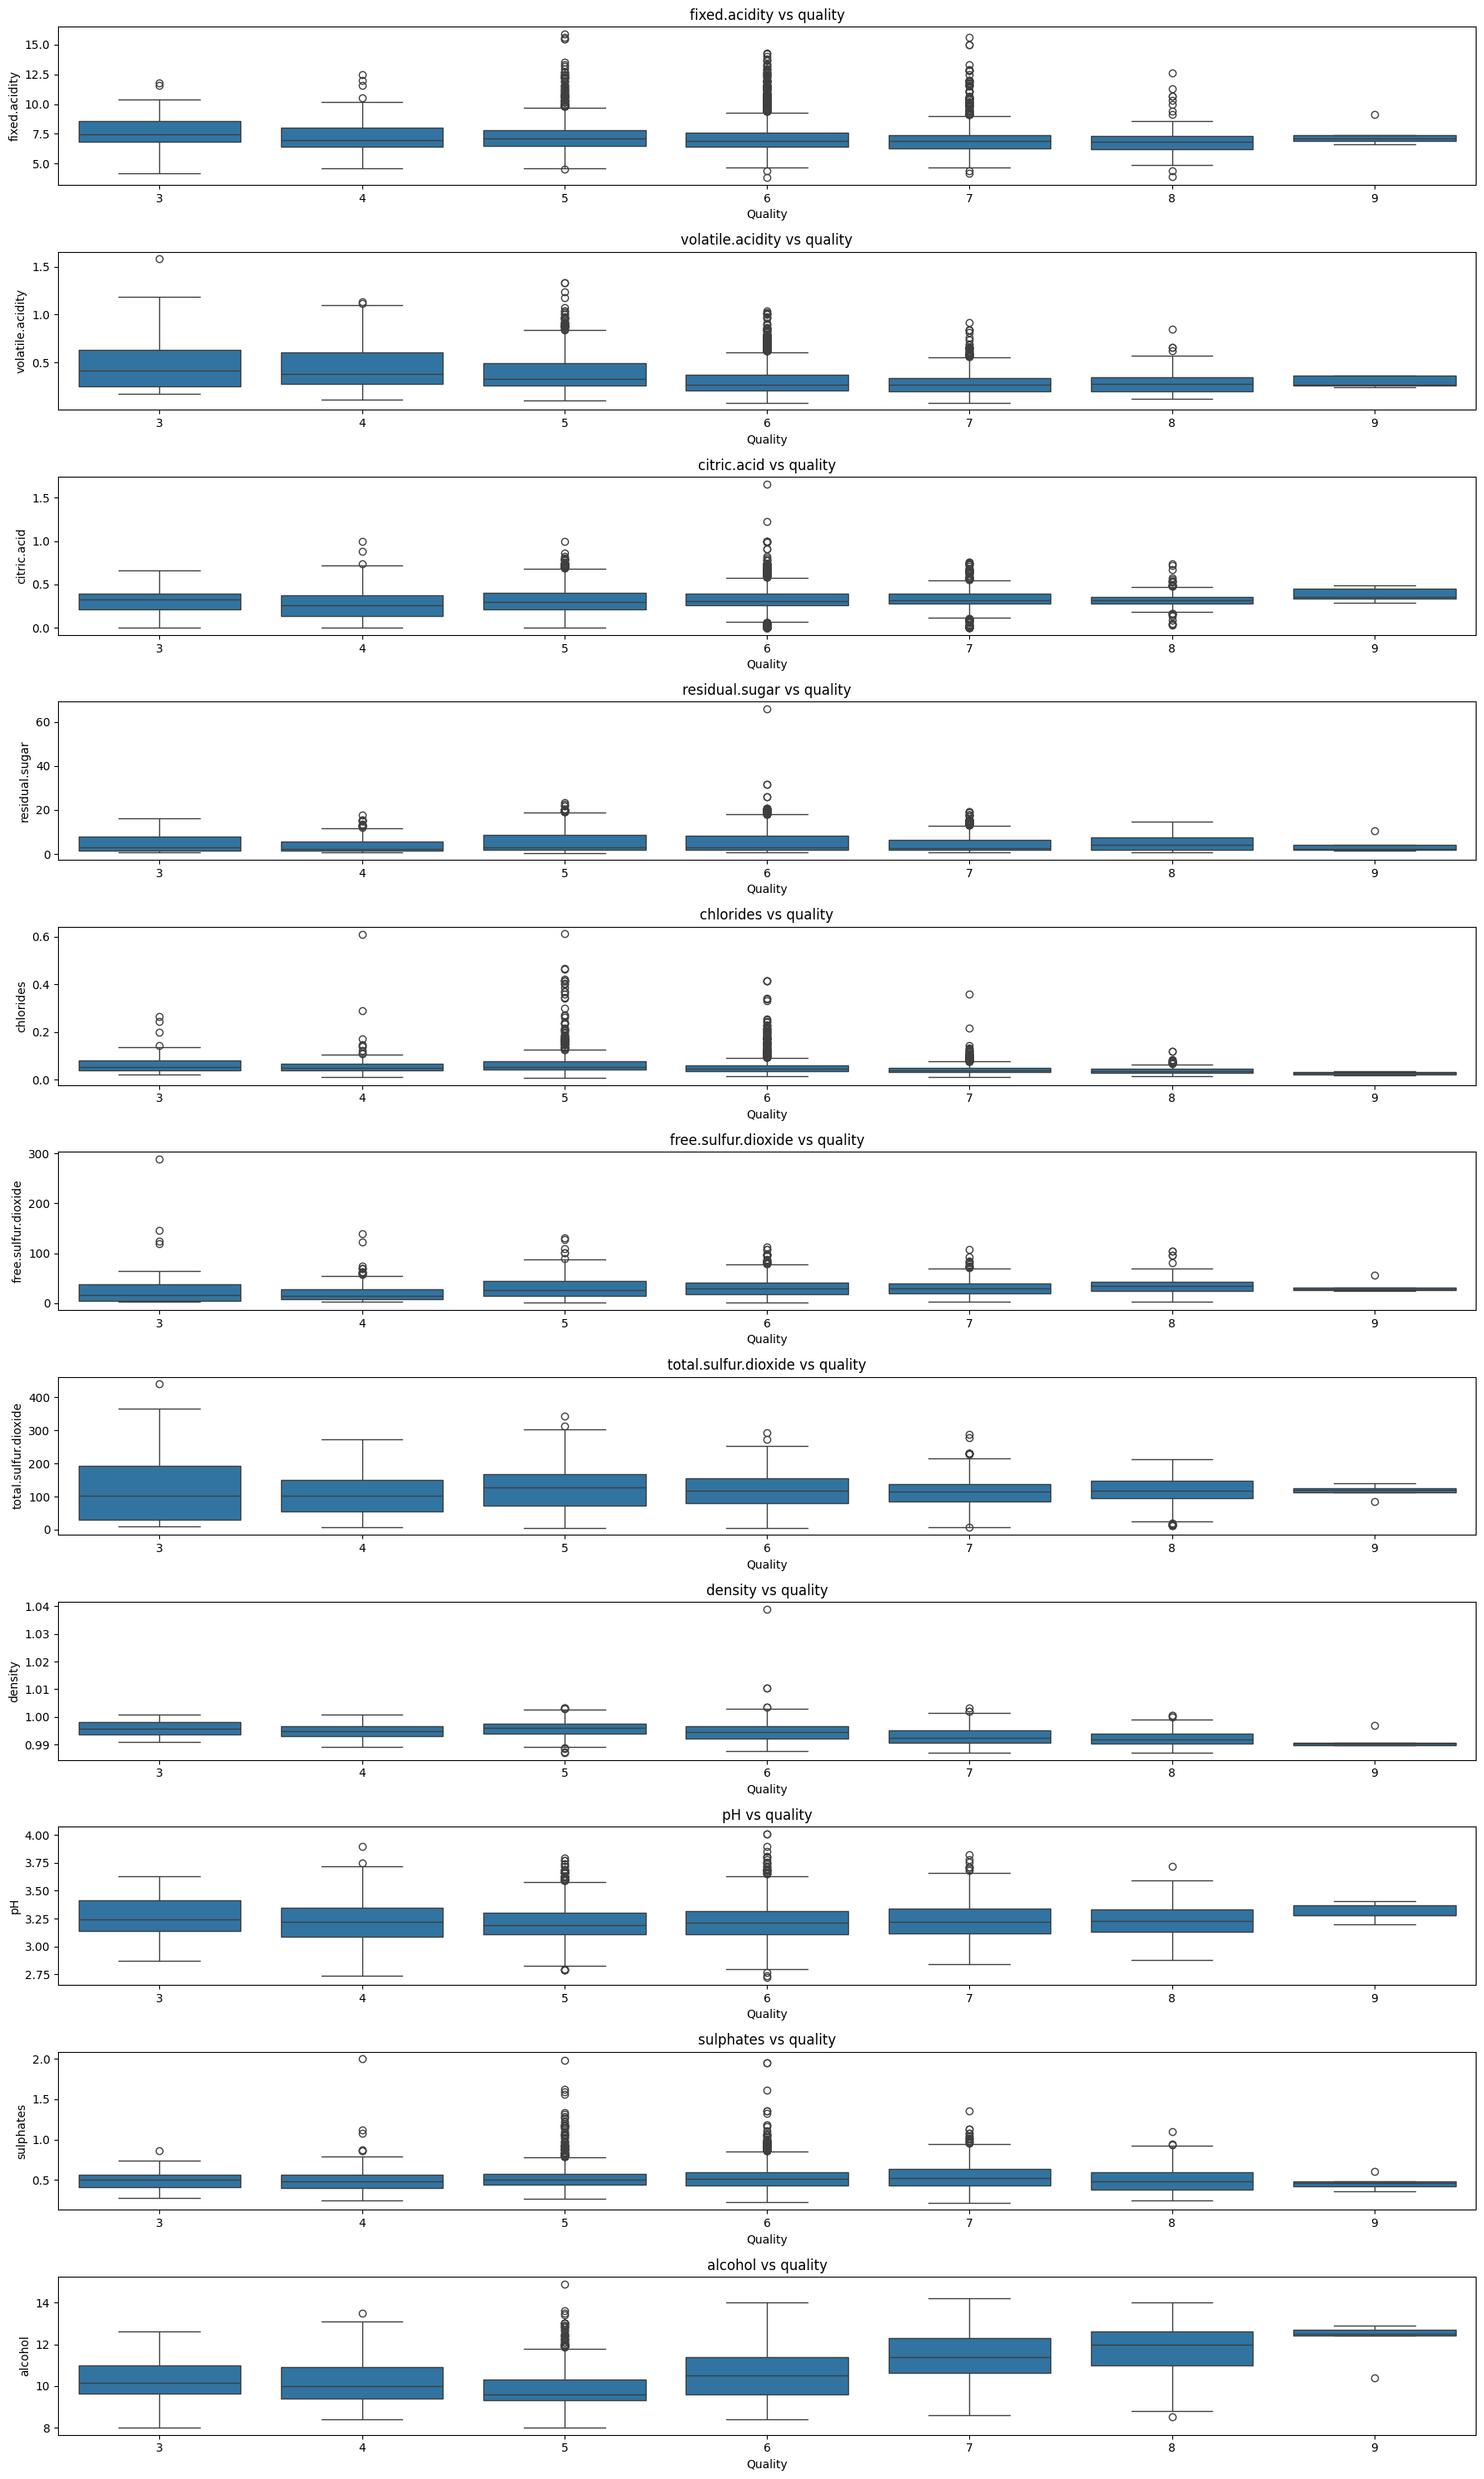

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "fixed.acidity", "volatile.acidity", "citric.acid", "residual.sugar",
    "chlorides", "free.sulfur.dioxide", "total.sulfur.dioxide",
    "density", "pH", "sulphates", "alcohol"
]

plt.figure(figsize=(18, 30))

for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    sns.boxplot(x="quality", y=feature, data=df)
    plt.title(f"{feature} vs quality")
    plt.xlabel("Quality")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


выбираем релевантные параметры:

volatile.acidity: высокие значения - больше вероятность низкого качества

citric.acid: низкие значение - больше вероятность низкого качества

chlorides: ниже значение - выше качество

free.sulfur.dioxide: низкие значения - больше вероятность низкого качества

density: ниже значение - выше качество

alcohol: высокие значения - больше вероятность высокого качества

In [146]:
# Создаем новую целевую переменную wine_group, в процессе выяснилось, что модели слишком часто путают соседние показатели качества, и F1 показывает слишком плохие результаты, больше классов в данном случае лучше оценивать RMSE и тд
def quality_to_group(q):
    if q <= 5:
        return "low"
    elif q <= 7:
        return "medium"
    else:
        return "high"

df["target"] = df["quality"].apply(quality_to_group)

# Проверим распределение классов
print(df["target"].value_counts())
selected_features = [
    "volatile.acidity",
    "citric.acid",
    "chlorides",
    "free.sulfur.dioxide",
    "density",
    "alcohol"
]

X = df[selected_features]
y = df['target']

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


target
medium    3915
low       2384
high       198
Name: count, dtype: int64


Обучение

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

log_lr = LogisticRegression(max_iter=1000, solver="lbfgs")

pipeline_lr = Pipeline([
    ("preprocess", preprocessor),
    ("clf", log_lr)
])

pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)

print("=== Logistic Regression (3 класса) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_lr), 3))
print("F1-macro:", round(f1_score(y_test, pred_lr, average="macro"), 3))


=== Logistic Regression (3 класса) ===
Accuracy: 0.719
F1-macro: 0.47


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)

pipeline_rf = Pipeline([
    ("preprocess", preprocessor),
    ("clf", rf_model)
])

pipeline_rf.fit(X_train, y_train)

pred_rf = pipeline_rf.predict(X_test)

print("=== Random Forest (3 класса) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_rf), 3))
print("F1-macro:", round(f1_score(y_test, pred_rf, average='macro'), 3))


=== Random Forest (3 класса) ===
Accuracy: 0.777
F1-macro: 0.711


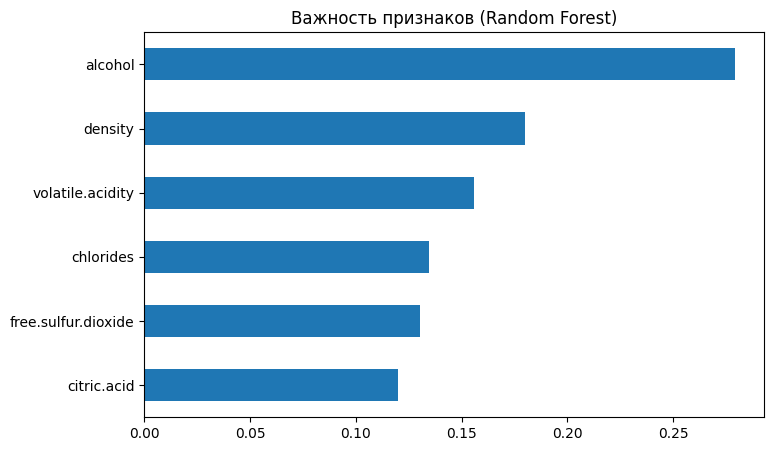

alcohol                0.279246
density                0.179963
volatile.acidity       0.155860
chlorides              0.134551
free.sulfur.dioxide    0.130374
citric.acid            0.120006
dtype: float64


In [162]:
import pandas as pd
import matplotlib.pyplot as plt

rf = pipeline_rf.named_steps["clf"]

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title("Важность признаков (Random Forest)")
plt.show()

print(importances.sort_values(ascending=False))


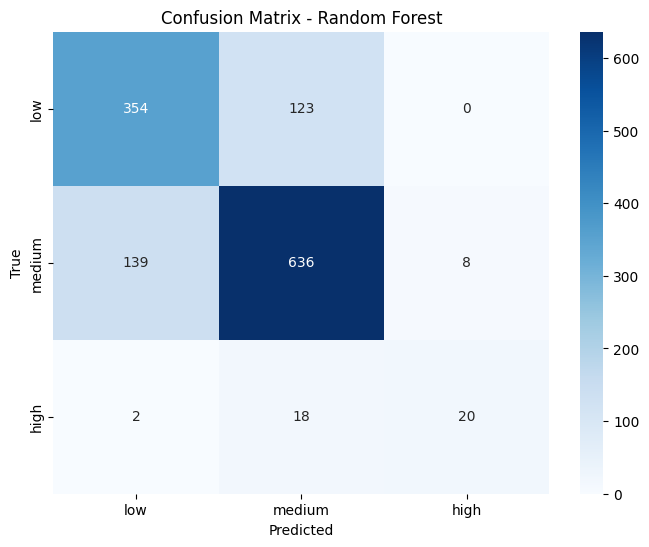

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_order = ["low", "medium", "high"]

cm = confusion_matrix(y_test, pred_rf, labels=class_order)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_order,
            yticklabels=class_order)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()


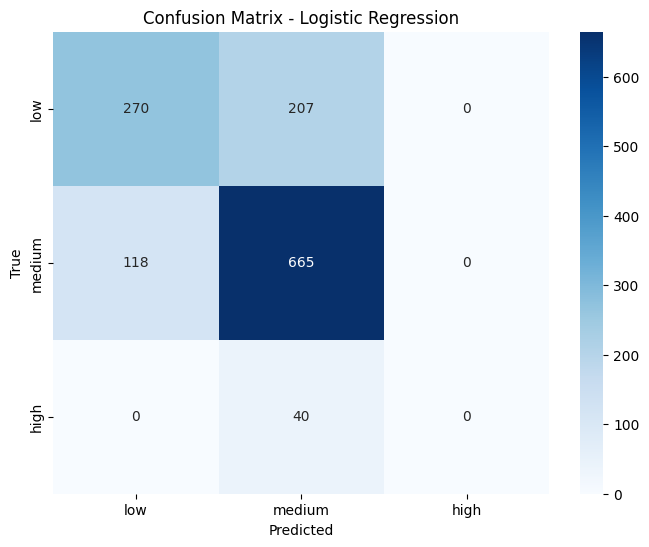

In [164]:
cm = confusion_matrix(y_test, pred_lr, labels=class_order)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_order,
            yticklabels=class_order)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [165]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred_rf, digits=3)
print(report)


              precision    recall  f1-score   support

        high      0.714     0.500     0.588        40
         low      0.715     0.742     0.728       477
      medium      0.819     0.812     0.815       783

    accuracy                          0.777      1300
   macro avg      0.749     0.685     0.711      1300
weighted avg      0.777     0.777     0.776      1300



In [167]:
report = classification_report(y_test, pred_lr, digits=3, zero_division=0)
print(report)

              precision    recall  f1-score   support

        high      0.000     0.000     0.000        40
         low      0.696     0.566     0.624       477
      medium      0.729     0.849     0.785       783

    accuracy                          0.719      1300
   macro avg      0.475     0.472     0.470      1300
weighted avg      0.695     0.719     0.702      1300



Medium — самый предсказуемый класс, т.к. много примеров (783).

High — наименее предсказуемый, потому что мало примеров (40), recall низкий или 0.

Low — средний уровень предсказаний; иногда путается с medium.

Random Forest (первая модель) справляется лучше, особенно для medium и high(для high разница колоссальная).

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

# Список экспериментов
params = [
    {"max_depth": 8, "n_estimators": 100},
    {"max_depth": 12, "n_estimators": 300},
    {"max_depth": 15, "n_estimators": 500}
]

for p in params:
    rf = RandomForestClassifier(
        max_depth=p["max_depth"],
        n_estimators=p["n_estimators"],
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42
    )
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", rf)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    print(f"max_depth={p['max_depth']}, n_estimators={p['n_estimators']} -> Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")


max_depth=8, n_estimators=100 -> Accuracy: 0.701, F1-macro: 0.602
max_depth=12, n_estimators=300 -> Accuracy: 0.777, F1-macro: 0.711
max_depth=15, n_estimators=500 -> Accuracy: 0.793, F1-macro: 0.735


при увеличении параметром добились неплохого "бесплатного" улучшения

In [171]:
features_minus_alcohol = [f for f in selected_features if f != "alcohol"]

X_train_minus = X_train[features_minus_alcohol]
X_test_minus = X_test[features_minus_alcohol]

rf = RandomForestClassifier(
    max_depth=15,
    n_estimators=500,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", rf)
])
pipeline.fit(X_train_minus, y_train)
preds_minus = pipeline.predict(X_test_minus)
acc_minus = accuracy_score(y_test, preds_minus)
f1_minus = f1_score(y_test, preds_minus, average="macro")

print(f"Без alcohol -> Accuracy: {acc_minus:.3f}, F1-macro: {f1_minus:.3f}")


Без alcohol -> Accuracy: 0.773, F1-macro: 0.717


Количество алкоголя, как и удтверждалось выше, важный параметр

In [172]:
from sklearn.model_selection import cross_val_score
import numpy as np

rf = RandomForestClassifier(
    max_depth=12,
    n_estimators=300,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", rf)
])

scores = cross_val_score(pipeline, X, y, cv=5, scoring="f1_macro")
print("Cross-val F1-macro (5 folds):", np.round(scores,3))
print("Mean F1-macro:", np.round(np.mean(scores),3))


Cross-val F1-macro (5 folds): [0.331 0.425 0.478 0.52  0.493]
Mean F1-macro: 0.449


1) На выбранном датасете лучше всего показал себя Random Forest.

Причины:

Устойчив к нелинейным зависимостям между признаками и качеством вина.

Автоматически оценивает важность признаков и снижает переобучение.


Метрики (7 классов качества 3–9):

Accuracy: 0.588

F1-macro: 0.344

RMSE: 0.79


Метрики (3 класса качества):

Accuracy: 0.777

F1-macro: 0.711


Кросс-валидация (5 folds):

F1-macro по fold’ам: [0.331, 0.425, 0.478, 0.520, 0.493]

Среднее F1-macro: 0.449

Вывод: модель стабильна, а показатели кросс-валидации подтверждают общее качество, учитывая дисбаланс классов.


2) Важные признаки

Разобрано выше, самый влиятельный параметр - количество алкоголя

3) Ошибки модели

Средние классы (6–7) предсказываются лучше всего — большинство примеров.

Модель склонна путать соседние классы (например, 4 и 5, 7 и 8), вследствие чего было решено объединить классы

Высокие классы (8-9) предсказываются хуже всего из-за маленького объема данных по ним

4) Кросс-валидация

Реализована с 5-fold cross-validation.

Позволяет оценить устойчивость модели на разных разбиениях данных.

Среднее F1-macro = 0.449, даёт более реалистичную оценку качества, чем одиночный train/test split.

Разброс по fold’ам показывает, что результаты зависят от конкретного разбиения, особенно для редких классов.